In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
class MCMCSampler:
    def __init__(self, log_posterior, proposal_std=0.5):
        self.log_posterior = log_posterior
        self.proposal_std = proposal_std

    def metropolis_hastings(self, initial_value, num_samples=10000, burn_in=1000, thin=1):
        samples = np.empty(num_samples + burn_in)
        samples[0] = initial_value
        current = initial_value
        current_log_post = self.log_posterior(current)

        for i in range(1, num_samples + burn_in):
            proposal = np.abs(np.random.normal(current, self.proposal_std))  # Keep values positive
            proposal_log_post = self.log_posterior(proposal)
            log_acceptance_ratio = proposal_log_post - current_log_post

            if np.log(np.random.rand()) < log_acceptance_ratio:
                current = proposal
                current_log_post = proposal_log_post

            samples[i] = current

        return samples[burn_in:][::thin]  # Discard burn-in and thin chain

    @staticmethod
    def compute_hdi(samples, credible_interval=0.95):
        samples = np.sort(np.asarray(samples))
        ci_index = max(1, int(np.floor(credible_interval * len(samples))))

        intervals_min = samples[:len(samples) - ci_index]
        intervals_max = samples[ci_index:]
        interval_widths = intervals_max - intervals_min

        min_index = np.argmin(interval_widths)
        return intervals_min[min_index], intervals_max[min_index]

    @staticmethod
    def compute_map(samples):
        """Compute the Maximum A Posteriori (MAP) estimate (highest density point)."""
        hist, bin_edges = np.histogram(samples, bins=50, density=True)  # Histogram density
        max_bin_index = np.argmax(hist)  # Find bin with max density
        map_estimate = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2  # Midpoint of bin
        return map_estimate

    def compute_summary(self, samples, credible_intervals=[0.5, 0.75, 0.95]):
        """Compute MAP, HDIs, and max value."""
        map_estimate = self.compute_map(samples)
        hdi_intervals = {ci: self.compute_hdi(samples, ci) for ci in credible_intervals}
        max_value = np.max(samples)

        return {
            "MAP": map_estimate,
            "HDIs": hdi_intervals,
            "Max Value": max_value
        }


In [3]:
# Define Zero-Inflated Right-Skewed Log-Posterior
def log_posterior(theta):
    p = 0.3  # Probability of zero inflation
    alpha, beta = 2, 1  # Gamma distribution shape and scale

    data = np.array([0, 0, 0, 1.2, 0.5, 3.0, 7.5, 2.3, 8.1, 0])  # Example data with zeros
    log_likelihood = np.sum(
        np.log(p * (data == 0) + (1 - p) * stats.gamma.pdf(data, a=alpha, scale=1/beta) * (data > 0))
    )

    log_prior = stats.gamma.logpdf(theta, a=alpha, scale=1/beta)  # Prior for theta
    return log_likelihood + log_prior  # Posterior ∝ Likelihood * Prior

# Run MCMC Sampling
sampler = MCMCSampler(log_posterior, proposal_std=0.5)
samples = sampler.metropolis_hastings(initial_value=1.0, num_samples=20000)

# Compute Summary Stats
summary = sampler.compute_summary(samples, credible_intervals=[0.5, 0.75, 0.95])

# Extract values
map_estimate = summary["MAP"]
hdi_intervals = summary["HDIs"]
max_value = summary["Max Value"]


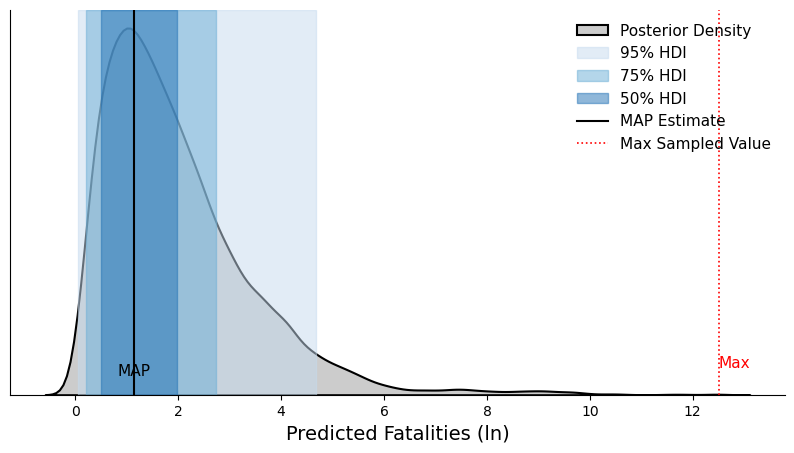

In [4]:

def plot_posterior(samples, hdi_intervals, map_estimate, max_value, color_scheme="gray"):
    """
    Plots a posterior distribution with HDIs, MAP estimate, and max sampled value
    using a clean, scientific, and Tufte-inspired aesthetic.

    Args:
        samples (array-like): Posterior samples.
        hdi_intervals (dict): Dictionary of HDI intervals {credible_level: (low, high)}.
        map_estimate (float): Maximum a posteriori (MAP) estimate.
        max_value (float): Maximum sampled value.
        color_scheme (str): "gray" for shades of gray, "blue" for shades of blue.
    """
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Choose colors based on the scheme
    if color_scheme == "gray":
        hdi_colors = ["#D9D9D9", "#A6A6A6", "#737373"]  # Light, Medium, Dark Gray
    elif color_scheme == "blue":
        hdi_colors = ["#C6DBEF", "#6BAED6", "#2171B5"]  # Light, Medium, Dark Blue
    else:
        raise ValueError("Invalid color_scheme. Use 'gray' or 'blue'.")

    # Plot smooth density (KDE) instead of histogram
    sns.kdeplot(samples, color="black", linewidth=1.5, fill=True, alpha=0.2, label="Posterior Density")

    # HDI shading for multiple credible intervals (largest first)
    for idx, (ci, (hdi_low, hdi_high)) in enumerate(sorted(hdi_intervals.items(), reverse=True)):
        label = f"{int(ci*100)}% HDI"
        color = hdi_colors[idx % len(hdi_colors)]  # Cycle through the three colors
        ax.axvspan(hdi_low, hdi_high, color=color, alpha=0.5, label=label)

    # MAP Estimate (Highest Density Point)
    ax.axvline(map_estimate, color="black", linestyle="-", linewidth=1.5, label="MAP Estimate")
    ax.text(map_estimate, plt.ylim()[1] * 0.05, "MAP", ha="center", fontsize=11, color="black")

    # Max Value (Extreme Sample)
    ax.axvline(max_value, color="red", linestyle=":", linewidth=1.2, label="Max Sampled Value")
    ax.text(max_value, plt.ylim()[1] * 0.07, "Max", ha="left", fontsize=11, color="red")

    # Minimalist aesthetics
    sns.despine()  # Remove spines for cleaner look
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel(r"Predicted Fatalities (ln)", fontsize=14)  # LaTeX-style label
    ax.set_ylabel("")  # No y-label for cleaner aesthetics

    # Add legend with all HDIs, MAP, and Max
    ax.legend(loc="upper right", frameon=False, fontsize=11)

    # Show the plot
    plt.show()

# Example Usage:
plot_posterior(samples, hdi_intervals, map_estimate, max_value, color_scheme="blue")
